# Transfer learning

Das Ziel des Transferlearning ist es, ein bereits trainiertes Modell auf eine andere Aufgabe zu trainieren. Die Idee dahinter ist den Teil des Netzwerks, der für die Extraktion von Merkmalen zuständig ist, zu "recyceln". Da dies in der Regel der teuerste Teil des Trainings ist, spart man sich dadurch eine Menge an Zeit. Das bedeutet, dass dieser Teil nicht neu trainiert werden muss, sondern die bereits trainierte Featurextraktion genauso gut für eine ähnliche Aufgabe verwendet werden kann. Aus diesem Grund sollte man ein bereits trainiertes Netzwerk nutzen, welches für eine ähnliche Aufgabe trainiert wurde. Lediglich die Klassifikationsschicht wird neu trainiert. Ziel dieses Notebooks ist es, ein Verständnis zu bekommen, was beim Transferlearning passiert.

Schauen Sie sich folgendes Notebook an und versuchen Sie den groben Ablauf zu verstehen.
Sie werden die meisten Befehle die Sie benötigen darin finden.
https://www.tensorflow.org/tutorials/images/transfer_learning

Für diese Aufgabe wollen wir das in der letzten Aufgabe trainierte Convolutional Neural Network, welches auf dem Mnist Datensatz trainiert wurde, auf eine andere Aufgabe trainieren. Die Aufgabe des Netzwerks soll es sein, Hexadezimalzahlen zu erkennen.
Hierzu verwenden wir den $\textit{emnist}$ Datensatz. Dieser beinhaltet zusätzlich das Alphabet (große und kleine Buchstaben). Näheres dazu unter https://pypi.org/project/emnist/ 

Gehen Sie dazu wie folgt vor:

    * Laden Sie ihr Modell aus der vorherigen Aufgabe mit tf.keras.models.load_model("Name des Modells") Falls Sie ihr Modell nicht gespeichert hatten, können Sie dies mit model.save("Name des Modells"), nachdem Sie erneut trainiert haben, tun.
      
    * Bereiten Sie den emnist-Datensatz wie in der vorherigen Aufgabe vor und sortieren Sie alle Kleinbuchstaben sowie alle Buchstaben, die nicht der Hexadezimalschreibweise angehören, aus!
      
    * Laden Sie das zuvor gespeicherte Modell und entfernen Sie die letzte Schicht ( model.pop() )
    
    * Frieren Sie das Modell ein, d.h. Sie setzen die Layer auf nicht trainierbar
    
    * Fügen Sie eine neue Schicht hinzu, sodass die verschiedenen Klassen (0-F) klassifiziert werden können (Wir beschränken uns hier auf die groß geschriebenen Buchstaben)
    
    * Trainieren Sie das Netzwerk mit den transformierten Labels
    
    * Plotten Sie wieder die Trainingskurven und erstellen sie eine confusion Matrix

In [127]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from sklearn.metrics import confusion_matrix 
from extra_keras_datasets import emnist
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras import optimizers

In [128]:
# Vorbereiten von Nist
(x_train, y_train), (x_test, y_test) = emnist.load_data(type='balanced')
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

INFO:root:Loading dataset = emnist


(112800, 28, 28)
(112800,)
(18800, 28, 28)
(18800,)


In [129]:
# Sortieren Sie alle Ziffern aus, die unerwünscht sind!
# Hinweis: np.where ist hierfür recht Hilfreich

# Trainingsdaten sortieren
x_train_hex = list()
y_train_hex = list()
for i in range(0,112800):
    if y_train[i] < 16:
        x_train_hex.append(x_train[i,:,:])
        y_train_hex.append(y_train[i])
x_train_hex = np.array(x_train_hex)
y_train_hex = np.array(y_train_hex)

# Testdaten sortieren
x_test_hex = list()
y_test_hex = list()
for i in range(0,18800):
    if y_test[i] < 16:
        x_test_hex.append(x_test[i,:,:])
        y_test_hex.append(y_test[i])
x_test_hex = np.array(x_test_hex)
y_test_hex = np.array(y_test_hex)


print(x_train_hex.shape)
print(y_train_hex.shape)
print(x_test_hex.shape)
print(y_test_hex.shape)

(38400, 28, 28)
(38400,)
(6400, 28, 28)
(6400,)


<ipython-input-130-fa68b64742ad>:6: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.title('true label: '+np.str(y_train_hex[i]))


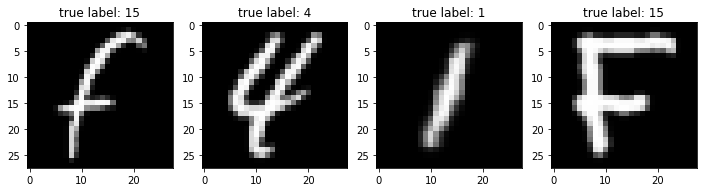

In [130]:
# Plotten Sie hier ein paar Ziffern!
plt.figure(figsize=(12,12))
for i in range(0,4):
    plt.subplot(1,4,(i+1))
    plt.imshow((x_train_hex[i,:,:]),cmap="gray")
    plt.title('true label: '+np.str(y_train_hex[i]))
    #plt.axis('off')

In [131]:
# Normalisieren Sie das Set und bringen es in die richtige "shape"

X_train=x_train_hex / 255 #divide by 255 so that they are in range 0 to 1
Y_train=keras.utils.to_categorical(y_train_hex, 16) # one-hot encoding

X_test=x_test_hex / 255
Y_test=keras.utils.to_categorical(y_test_hex, 16)

X_train=np.reshape(X_train, (X_train.shape[0],28,28,1))
X_test=np.reshape(X_test, (X_test.shape[0],28,28,1))

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(38400, 28, 28, 1)
(6400, 28, 28, 1)
(38400, 16)
(6400, 16)


In [132]:
# Laden des Modells
base_model = tf.keras.models.load_model('cnn_mnist')
model = tf.keras.models.load_model('cnn_mnist')

#Hier die letzte Schicht entfernen
model.pop()

In [133]:

# Modell einfrieren
# model.trainable=False

# Basismodell als Ausgangspunkt nehmen
# inputs = tf.keras.Input(shape=(28, 28,1))
# x = base_model(inputs, training=False)

# Hier einen Dense-layer und einmal Softmax hinzufügen, sodass die verschiedenen Klassen vorhergesagt werden! können!
# last_layer = ...(x)
# output     = tf.keras.layers.Activation('softmax')(last_layer)

# Modell Zusammenfügen
# model = tf.keras.Model(inputs, output)


model.add(Dense(16, activation='softmax'))
for layer in model.layers[:5]:
        layer.trainable = False

In [134]:
# Modell Kompilieren, Kostenfunktion categorical_crossentropy, Optimizer Adam mit der learningrate 1e-4
learning_rate = 1e-4
opt = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                25616     
Total params: 44,432
Trainable params: 25,616
Non-trainable params: 18,816
_____________________________________________

In [135]:
# Accuracy vor dem Transferlearning bestimmen
loss0, accuracy0 = model.evaluate(x = X_test,y = Y_test)

200/200 [==============================] - 0s 2ms/step - loss: 3.7031 - accuracy: 0.0700


In [136]:
# Hier das Netzwerk für 10 Epochen trainieren!
history=model.fit(X_train[0:32000], Y_train[0:32000], 
                  batch_size=128, 
                  epochs=10,
                  verbose=2, 
                  validation_data=(X_train[32000:38400], Y_train[32000:38400])
                 )

Epoch 1/10
250/250 - 2s - loss: 1.3765 - accuracy: 0.6293 - val_loss: 0.6123 - val_accuracy: 0.8644
Epoch 2/10
250/250 - 1s - loss: 0.4612 - accuracy: 0.8930 - val_loss: 0.3652 - val_accuracy: 0.9153
Epoch 3/10
250/250 - 1s - loss: 0.3128 - accuracy: 0.9251 - val_loss: 0.2775 - val_accuracy: 0.9320
Epoch 4/10
250/250 - 1s - loss: 0.2471 - accuracy: 0.9387 - val_loss: 0.2313 - val_accuracy: 0.9431
Epoch 5/10
250/250 - 2s - loss: 0.2084 - accuracy: 0.9485 - val_loss: 0.2010 - val_accuracy: 0.9505
Epoch 6/10
250/250 - 1s - loss: 0.1825 - accuracy: 0.9542 - val_loss: 0.1799 - val_accuracy: 0.9538
Epoch 7/10
250/250 - 1s - loss: 0.1636 - accuracy: 0.9584 - val_loss: 0.1648 - val_accuracy: 0.9558
Epoch 8/10
250/250 - 1s - loss: 0.1493 - accuracy: 0.9617 - val_loss: 0.1535 - val_accuracy: 0.9595
Epoch 9/10
250/250 - 1s - loss: 0.1381 - accuracy: 0.9646 - val_loss: 0.1440 - val_accuracy: 0.9622
Epoch 10/10
250/250 - 1s - loss: 0.1284 - accuracy: 0.9673 - val_loss: 0.1359 - val_accuracy: 0.9656

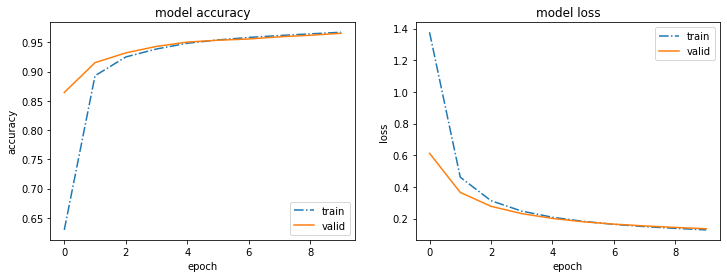

In [137]:
# Plotten der Trainingskurve wie in der Aufgabe zuvor
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right');

In [138]:
# Confusion Matrix erstellen
pred=model.predict(X_test)
print(confusion_matrix(np.argmax(Y_test,axis=1),np.argmax(pred,axis=1)))
acc_fc_orig = np.sum(np.argmax(Y_test,axis=1)==np.argmax(pred,axis=1))/len(pred)
print("Acc_fc_orig_flat = " , acc_fc_orig)

[[379   0   0   0   1   0   3   0   0   0   0   1   0  16   0   0]
 [  0 394   3   0   0   0   0   2   0   0   0   0   0   0   0   1]
 [  2   0 389   1   0   0   0   0   3   0   1   1   0   2   1   0]
 [  2   0   0 393   0   3   0   0   1   1   0   0   0   0   0   0]
 [  1   0   1   0 382   0   1   0   0   6   4   0   0   1   0   4]
 [  1   0   0   2   0 386   0   0   0   3   0   1   4   0   1   2]
 [  0   1   0   0   1   1 395   0   0   0   0   0   2   0   0   0]
 [  1   1   2   1   1   0   0 390   0   1   0   0   0   0   0   3]
 [  0   0   0   0   1   0   0   0 386   4   1   3   0   2   2   1]
 [  1   0   1   0   2   0   0   4   1 391   0   0   0   0   0   0]
 [  1   0   2   0   1   1   0   0   0   2 390   2   0   0   1   0]
 [  5   0   1   2   0   0   0   2  12   0   6 365   0   1   5   1]
 [  5   0   1   0   0   0   3   0   0   0   0   0 387   0   3   1]
 [ 24   0   1   1   0   0   0   1   0   0   2   2   0 369   0   0]
 [  0   0   1   0   0   1   1   0   1   1   0   1   1   0 387 

In [139]:
loss0, accuracy0 = model.evaluate(x = X_test,y = Y_test)

200/200 [==============================] - 0s 2ms/step - loss: 0.1338 - accuracy: 0.9645
